### The goal of this script is to  to create a dataframe of songs of various cities in the United States
 - scrape https://en.wikipedia.org/wiki/List_of_songs_about_cities#United_States

In [190]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup
import re
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

#### The main wiki page has a list of songs about cities from all over the world. Some of the bigger cities that have a lot of songs about it, have their own wiki pages

There didn't seem to be a clear pattern in the html through which I could extract just us cities, so I had to manually find the range of ines that I had to specify

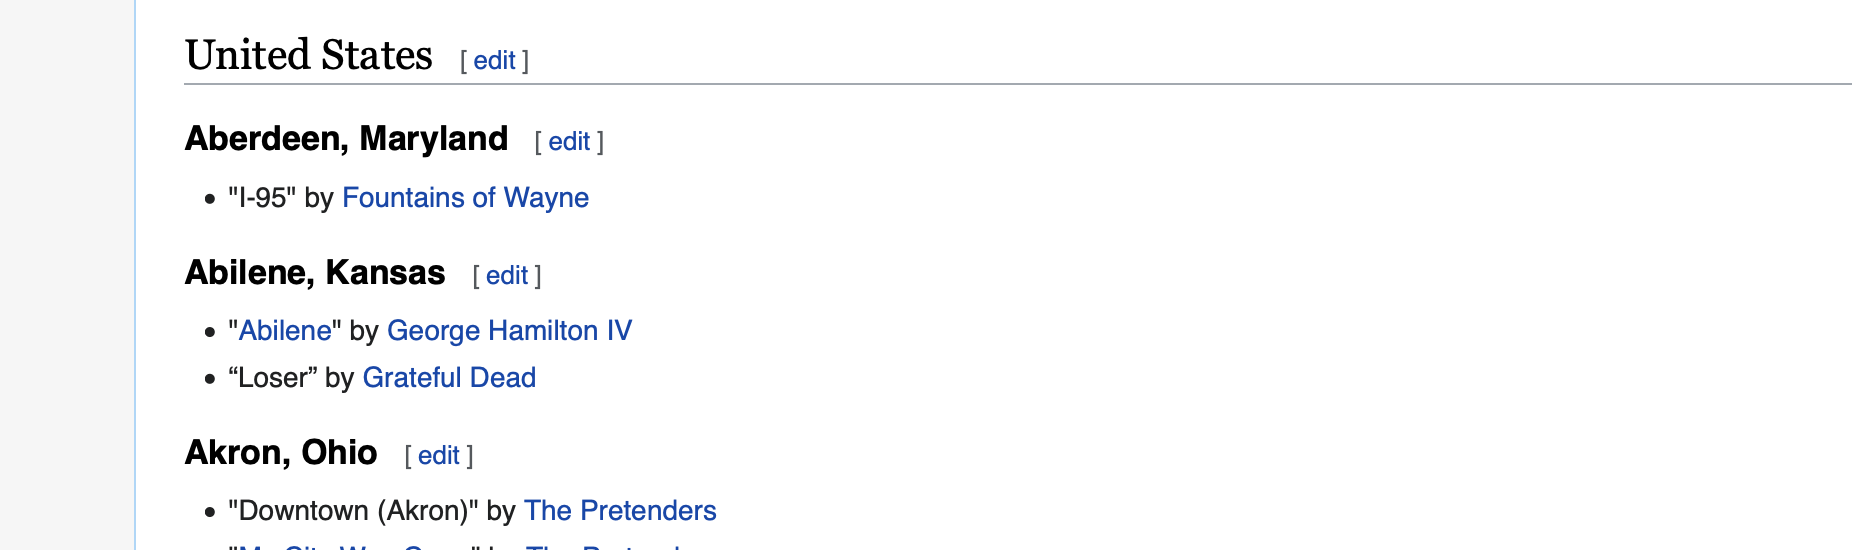

In [191]:
response = get("https://en.wikipedia.org/wiki/List_of_songs_about_cities#United_States")
html_soup = BeautifulSoup(response.text, 'html.parser')
h3s = html_soup.find_all("h3")

In [192]:
places = []
songs =[]
for i in range(352,502):
    places.append(h3s[i].text)
    songs.append(h3s[i].findNext("ul").text)

In [193]:
main_pg = pd.DataFrame({"places":places,"songs":songs})

In [194]:
#format text and reformat columns
main_pg[["city","state"]]=main_pg["places"].str.split(",",expand = True)

main_pg = (main_pg
 .set_index(["city","state"])
 .songs.str.split("\n",expand = True)
 .stack()
 .reset_index()
 .rename(columns={0:'songs'})
 .loc[:,["city","state","songs"]]
)
main_pg["state"] = main_pg["state"].str.split("[",expand = True).iloc[:,0]
main_pg[['_','song','artist']] =main_pg["songs"].str.replace("by","").str.split('"',expand =True,n=2)

In [195]:
main_pg

,city,state,songs,_,song,artist
0,Aberdeen,Maryland,"""I-95"" by Fountains of Wayne",,I-95,Fountains of Wayne
1,Abilene,Kansas,"""Abilene"" by George Hamilton IV",,Abilene,George Hamilton IV
2,Abilene,Kansas,“Loser” by Grateful Dead,“Loser” Grateful Dead,None,None
3,Akron,Ohio,"""Downtown (Akron)"" by The Pretenders",,Downtown (Akron),The Pretenders
4,Akron,Ohio,"""My City Was Gone"" by The Pretenders",,My City Was Gone,The Pretenders
...,...,...,...,...,...,...
638,Wichita,Kansas,"""Wichita Cathedral"" by Butthole Surfers",,Wichita Cathedral,Butthole Surfers
639,Wichita,Kansas,"""Wichita Lineman"" by Glen Campbell",,Wichita Lineman,Glen Campbell
640,Wichita,Kansas,"""Wichita Skyline"" by Shawn Colvin",,Wichita Skyline,Shawn Colvin
641,Wildwood,New Jersey,"""Wildwood Days"" by Bobby Rydell",,Wildwood Days,Bob Rydell


In the Wikipedia page, there are some cities which have so many songs that they have their own separate wikipages
The webscraper does not capture this, we need to manually get these.
Lets drop these repetetions and scrape their individual wiki pages

In [196]:
main_pg = (main_pg.
 drop_duplicates("songs",keep="last").
 dropna(subset =["song"]).
 reset_index(drop=True).
 loc[:,["state","city","song","artist"]]
)

### Scraping Individual Pages

In [197]:
#lists to keep songs and places info for all the songs from cities that have their own wiki pages of songs
places =[]
songs =[]

In [198]:
def print_songs_from_individual_cities(site,start,end,places,songs,city):
    """
    prints a list of songs from wiki page of the city 
    inputs:
        site: wiki page that has a similar format to https://en.wikipedia.org/wiki/List_of_songs_about_Atlanta
        start, end: starting and ending tag numbers(?) manuallyhad to figure out where the song started and ended
        places: list of names of the cities
        songs: list of the names of the songs
    """
    response = get(site)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    song =html_soup.find_all("li")
    for i in song[start:end]:
        print(i.text)

In [199]:
def scrape_songs_from_individual_cities(site,start,end,places,songs,city):
    """
    scrapes a list of songs from wiki page of the city 
    inputs:
        site: wiki page that has a similar format to https://en.wikipedia.org/wiki/List_of_songs_about_Atlanta
        start, end: starting and ending tag numbers(?) manuallyhad to figure out where the song started and ended
        places: list of names of the cities
        songs: list of the names of the songs
    output: places,songs
    """
    response = get(site)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    song =html_soup.find_all("li")
    for i in song[start:end]:
        places.append(city)
        songs.append(i.text)
    return places,songs

## Atlanta

In [160]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Atlanta"
places,songs = scrape_songs_from_individual_cities(site,0,-51,places,songs,"Atlanta, Georgia")

## Alabama

In [161]:
#The website for Alabama was slightly differently formatted
response = get("https://en.wikipedia.org/wiki/List_of_songs_about_Birmingham,_Alabama")
html_soup = BeautifulSoup(response.text, 'html.parser')
song =html_soup.find_all("li")
for i in song[:-54]:
    places.append("Birmingham, Alabama")
    songs.append(i.text.split(",")[1].strip() +"" +i.text.split(",")[0].strip())

## Boston

In [162]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Boston"
places,songs = scrape_songs_from_individual_cities(site,0,-171,places,songs,"Boston, Massachusetts")

## Chicago

In [163]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Chicago"
places,songs = scrape_songs_from_individual_cities(site,28,-101,places,songs,"Chicago, Illinois")

## Detroit

In [164]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Detroit"
places,songs = scrape_songs_from_individual_cities(site,28,-62,places,songs,"Chicago, Illinois")

## Los Angeles

In [165]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Los_Angeles"
places,songs = scrape_songs_from_individual_cities(site,12,-52,places,songs,"Los Angeles, California")

## Miami

In [166]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Miami"
places,songs = scrape_songs_from_individual_cities(site,5,-58,places,songs,"Miami, Florida")

## Nashville

In [167]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Nashville,_Tennessee"
places,songs = scrape_songs_from_individual_cities(site,27,-50,places,songs,"Nashville, Tennessee")

## New Orleans

In [168]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_New_Orleans"
places,songs = scrape_songs_from_individual_cities(site,27,-55,places,songs,"New Orleans, Louisiana")

## New York

In [169]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_New_York_City"
places,songs = scrape_songs_from_individual_cities(site,27,-135,places,songs,"New York City, New York")

## Oregon

In [170]:
site = "https://en.wikipedia.org/wiki/List_of_songs_about_Portland,_Oregon"
places,songs = scrape_songs_from_individual_cities(site,0,-67,places,songs,"Portland, Oregon")

## San Francisco

In [171]:
response = get("https://en.wikipedia.org/wiki/List_of_songs_about_California#San_Francisco_and_the_Bay_Area")
html_soup = BeautifulSoup(response.text, 'html.parser')
song =html_soup.find_all("tr")
for i in song[1:]:
    #print(i.text.split("\n")[1] +" - "+ i.text.split("\n")[2])
    songs.append(i.text.split("\n")[1] +" - "+ i.text.split("\n")[2])
    places.append("San Francisco, California")

In [172]:
#create a df of all these songs that were just scraped
individual_cities = pd.DataFrame(
    {'songs': songs,
     'places': places,
    })

In [173]:
individual_cities[["city","state"]] = individual_cities["places"].str.split(",",expand=True)

In [174]:
#format column and text
individual_cities[["placeholder","song","artist"]]=(individual_cities["songs"].
 str.replace("by","").
 str.replace("-","").
 str.replace(r"\((19|20)\d{2}\)","").                                         
 str.split('"',expand =True,n=2)
)

individual_cities = individual_cities[["state","city","song","artist"]]

In [175]:
#concatenate the 2 data frames
data_cleaned = pd.concat([main_pg, individual_cities]).reset_index(drop=True)

In [176]:
states = dict(tuple(data_cleaned.groupby('state')))


In [181]:
for state in states.keys():
    temp = pd.DataFrame(states[state]).reset_index(drop =True)
    temp["song"] = temp["song"].str.strip()
    temp["artist"] = temp["artist"].str.strip()
    temp.to_csv("./songs_wikipedia/"+str(state)+".csv")